## 1. Imports and Setup

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Mounted at /content/drive
Using device: cuda


## 2. Load and Prepare the Animal Dataset

Let's download and load the dataset and display a few random samples from it:

In [5]:
# 1. Define transform: resize, convert to tensor, normalize
# two transforms, one for train, one for test
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],  # ImageNet stats
                         [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# RandomHorizontalFlip, RandomRotation, ColorJitter are basic augmentations to artificially increase data variety for the model

# Resize to make all images the same size
# ToTensor because pytorch models work on tensors not PIL images
# Nomalize means the image's pixel will be scaled and shifted from [0,1] to [-1,1] for all 3 channels (RGB)
# Reason behind: Neural nets train faster and more reliably when input features are zero-centered and have similar scale

# 2. Set your dataset path
# data_dir = '/content/drive/MyDrive/U of T/AI Research - Selina X Ayman/archive/raw-img'

import zipfile
import os

# Path to the zip file in your Drive
zip_path = '/content/drive/MyDrive/U of T/AI Research - Selina X Ayman/archive.zip'
# Path to extract the images
extract_path = '/content/animals10-data' # unzipping into the colab machine directly instead of google drive as it's faster

# Unzip if not already done
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

# Set the image folder
data_dir = '/content/animals10-data/archive/raw-img'

Explanation:

This block resizes images, normalizes them, loads them from folders, splits into train/test, and creates batch loaders.

In [6]:
# SECOND VERSION SOLUTION
# This guarantees that for each class, the proportion of samples is preserved in both splits

from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Subset

# Load with default transform (will apply train/test transforms in the next step)
full_dataset = datasets.ImageFolder(root=data_dir)

all_targets = [label for _, label in full_dataset.imgs]
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

indices = list(range(len(full_dataset)))
for train_idx, test_idx in sss.split(indices, all_targets):
    pass

# We will re-wrap these subsets with their respective transforms
class CustomSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, idx):
        img, label = self.subset[idx]
        img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.subset)

# Subset without transform first (otherwise double transform is applied)
train_base = Subset(full_dataset, train_idx)
test_base = Subset(full_dataset, test_idx)
train_dataset = CustomSubset(train_base, train_transform)
test_dataset = CustomSubset(test_base, test_transform)

# PyTorch’s ImageFolder applies its transform to all images. To use different transforms for train/test, we wrap each subset in a CustomSubset that applies the right transform per split.

In [7]:
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## 3. Visualize Some Images

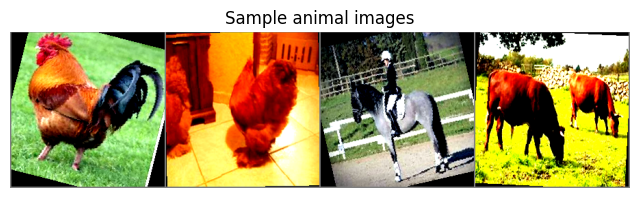

Labels: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


In [8]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize from [-1, 1] to [0, 1]
    npimg = img.numpy() # Converts the tensor to a numpy array, so matplotlib can plot it
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    # PyTorch images are in “channels first” (C, H, W) format (e.g., RGB, 64, 64).
    # Matplotlib expects “channels last” (H, W, C).
    # np.transpose reorders axes so the colors look right.
    plt.axis('off') # Hides axes for a cleaner image grid.

dataiter = iter(train_loader)
images, labels = next(dataiter)

plt.figure(figsize=(8,4)) # size of the image
imshow(torchvision.utils.make_grid(images[:4]))
plt.title('Sample animal images')
plt.show()
print("Labels:", full_dataset.classes)
# labels[:8] gives you the integer class labels from your batch.
# dataset.classes[l] translates integer labels back to human-readable animal names (e.g., "gatto", "pecora", ...).

## 4.1 Neural Network for Animal Classification

We'll first build a simple neural network consisting of two fully connected layers and apply this to the animal classification task. Our network will ultimately output a probability distribution over the 10 different classes (0-9).

## 4.2 Define the CNN Model

### Fully connected neural network architecture
To define the architecture of this first fully connected neural network, we'll once again use the the `torch.nn` modules, defining the model using [`nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html). Note how we first use a [`nn.Flatten`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) layer, which flattens the input so that it can be fed into the model.

In this next block, you'll define the fully connected layers of this simple network.

## Load EfficientNet-B0

In [9]:
# Number of output classes (should match your animal classes)
num_classes = len(full_dataset.classes) # which is 10

# Load EfficientNet-B0, pretrained on ImageNet
model = models.efficientnet_b0(weights="EfficientNet_B0_Weights.IMAGENET1K_V1")
# If above line fails, try: model = models.efficientnet_b0(pretrained=True)

# Replace the last classification layer
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

# (Optional: freeze feature extractor for faster convergence)
for param in model.features.parameters():
    param.requires_grad = False

model = model.to(device)
print(model)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 150MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

### Model Metrics and Training Parameters

Before training the model, we need to define components that govern its performance and guide its learning process. These include the loss function, optimizer, and evaluation metrics:

* *Loss function* — This defines how we measure how accurate the model is during training. As was covered in lecture, during training we want to minimize this function, which will "steer" the model in the right direction.
* *Optimizer* — This defines how the model is updated based on the data it sees and its loss function.
* *Metrics* — Here we can define metrics that we want to use to monitor the training and testing steps. In this example, we'll define and take a look at the *accuracy*, the fraction of the images that are correctly classified.

We'll start out by using a stochastic gradient descent (SGD) optimizer initialized with a learning rate of 0.1. Since we are performing a categorical classification task, we'll want to use the [cross entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

You'll want to experiment with both the choice of optimizer and learning rate and evaluate how these affect the accuracy of the trained model.

In [10]:
loss_function = nn.CrossEntropyLoss() # It compares the predicted class scores (“logits”) to the true labels
optimizer = optim.Adam(model.parameters(), lr=0.0003) # The optimizer tells the model how to update its weights after seeing how wrong it was (using the loss).

# Why did we use Adam?
# Adam = “Adaptive Moment Estimation”

# It’s a smart optimizer that:
# Adjusts the learning rate individually for every parameter (“weight”) in your network.
# Keeps track of momentum (average direction of past gradients) and scales updates by how variable gradients have been for each parameter.
# Can escape “bad luck” in training better than simple methods.

# What else could we use?
# SGD (Stochastic Gradient Descent):

# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# Pros: Simpler, sometimes yields better generalization (but can be slower and needs careful tuning).
# Cons: Can get stuck or take a long time to “find the path.”
# RMSprop, Adagrad, Adadelta, etc.:
# Each has its own way of adapting learning rates or smoothing out updates.

# Learning rate controls how big each update is. Too high? You overshoot. Too low? Training is slow.
# Rhe learning rate is 0.001 for Adam

### Train the model

In [11]:
def train(model, dataloader, loss_function, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
      # Epoch: One complete pass through the entire training dataset.
        total_loss = 0 # for averaging the loss
        correct = 0 # for accuray
        total = 0 # total images processed so far for this epoch
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device) # move the data to the GPU (if available)
            optimizer.zero_grad() # reset gradients to zero
            outputs = model(images)
            loss = loss_function(outputs, labels) # compute the loss
            loss.backward() # calculate the gradient (how much each weight in the model should change to reduce loss)
            optimizer.step() # updates model weights
            total_loss += loss.item() * images.size(0) # adds the loss for this batch
            _, predicted = torch.max(outputs, 1) # get the predicted class for each image in the batch
            total += labels.size(0)
            correct += (predicted == labels).sum().item() # counts how many images were correctly classified
        avg_loss = total_loss / total
        accuracy = correct / total
        train_losses.append(avg_loss) # Store the loss for plotting
        train_accuracies.append(accuracy) # Store the accuracy for plotting
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

In [12]:
EPOCHS = 25
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
train(model, train_loader, loss_function, optimizer, EPOCHS)

Epoch 1, Loss: 0.8602, Accuracy: 0.8243
Epoch 2, Loss: 0.3991, Accuracy: 0.8971
Epoch 3, Loss: 0.3324, Accuracy: 0.9058
Epoch 4, Loss: 0.3060, Accuracy: 0.9118
Epoch 5, Loss: 0.2864, Accuracy: 0.9145
Epoch 6, Loss: 0.2744, Accuracy: 0.9176
Epoch 7, Loss: 0.2646, Accuracy: 0.9177
Epoch 8, Loss: 0.2601, Accuracy: 0.9194
Epoch 9, Loss: 0.2593, Accuracy: 0.9194
Epoch 10, Loss: 0.2547, Accuracy: 0.9220
Epoch 11, Loss: 0.2515, Accuracy: 0.9203
Epoch 12, Loss: 0.2431, Accuracy: 0.9262
Epoch 13, Loss: 0.2394, Accuracy: 0.9252
Epoch 14, Loss: 0.2368, Accuracy: 0.9261
Epoch 15, Loss: 0.2444, Accuracy: 0.9232
Epoch 16, Loss: 0.2336, Accuracy: 0.9258
Epoch 17, Loss: 0.2320, Accuracy: 0.9270
Epoch 18, Loss: 0.2348, Accuracy: 0.9242
Epoch 19, Loss: 0.2337, Accuracy: 0.9253
Epoch 20, Loss: 0.2269, Accuracy: 0.9261
Epoch 21, Loss: 0.2311, Accuracy: 0.9267
Epoch 22, Loss: 0.2218, Accuracy: 0.9291
Epoch 23, Loss: 0.2282, Accuracy: 0.9270
Epoch 24, Loss: 0.2246, Accuracy: 0.9286
Epoch 25, Loss: 0.2236, A

As the model trains, the loss and accuracy metrics are displayed. With five epochs and a learning rate of 0.01, this fully connected model should achieve an accuracy of approximatley 0.93 (or 93%) on the training data.

## Plotting Curves

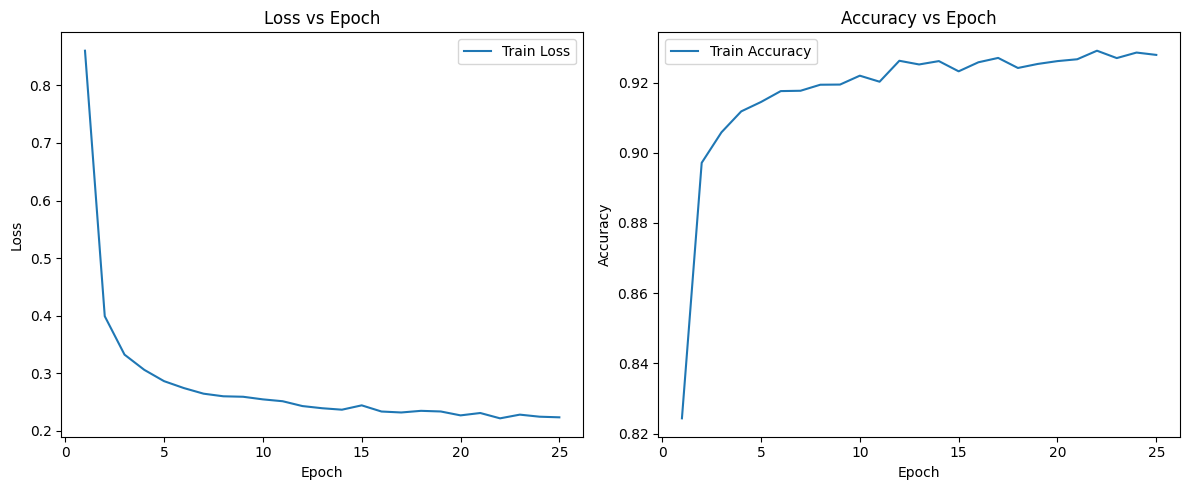

In [13]:
import matplotlib.pyplot as plt

epochs_range = range(1, EPOCHS+1)
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs_range, train_losses, label='Train Loss')
# plt.plot(epochs_range, val_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epoch')

plt.subplot(1,2,2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
# plt.plot(epochs_range, val_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs Epoch')

plt.tight_layout()
plt.show()

### Evaluate the CNN Model

Now that we've trained the model, let's evaluate it on the test dataset.

In [14]:
def evaluate(model, dataloader, loss_function):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad(): # disable gradient calculations as we're not updating weights, just measuring performance. Saves memory and speeds things up.
        for images, labels in dataloader: #  Loop over the test data in batches
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_function(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1) # Get the predicted class index for each image (the class with the highest score)
            total += labels.size(0) # Add the total number of images together
            correct += (predicted == labels).sum().item() # Count how many were predicted correctly
    avg_loss = test_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

test_loss, test_acc = evaluate(model, test_loader, loss_function)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

Test Loss: 0.17178140111648918
Test Accuracy: 0.9484339190221543


You may observe that the accuracy on the test dataset is a little lower than the accuracy on the training dataset. This gap between training accuracy and test accuracy is an example of *overfitting*, when a machine learning model performs worse on new data than on its training data.


### Make predictions with the CNN model

With the model trained, we can use it to make predictions about some images.

In [15]:
# Collect all test predictions, labels, and images for visualization
all_probs = []
all_preds = []
all_true = []
all_imgs = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images.to(device))
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)
        all_probs.append(probs.cpu())
        all_preds.append(preds.cpu())
        all_true.append(labels.cpu())
        all_imgs.append(images.cpu())

all_probs = torch.cat(all_probs)
all_preds = torch.cat(all_preds)
all_true = torch.cat(all_true)
all_imgs = torch.cat(all_imgs)

Plot a Grid of Images with Model Predictions

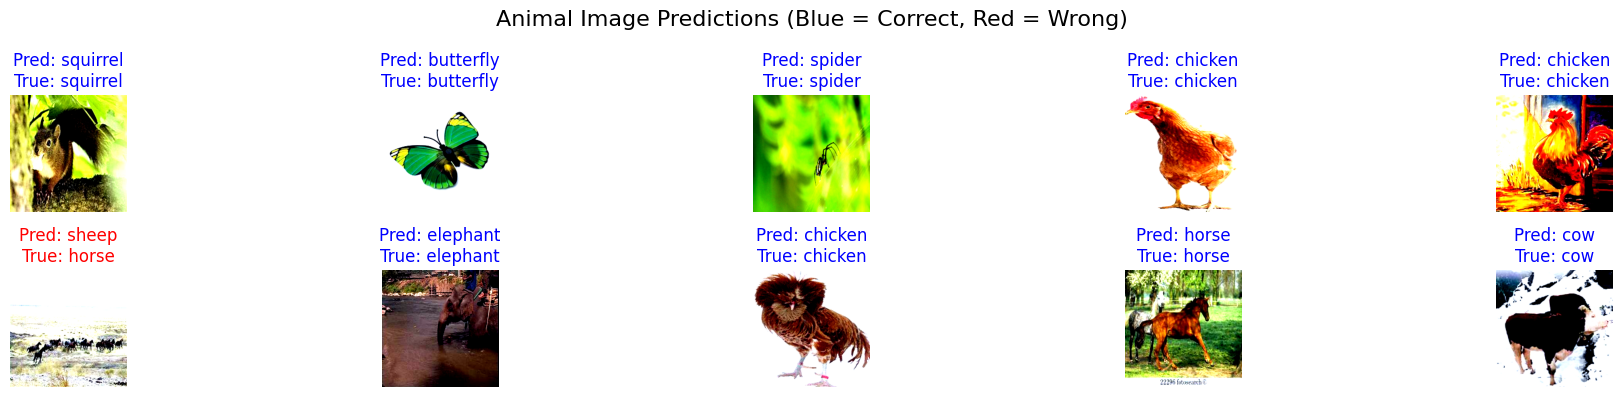

In [17]:
translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel", "dog": "cane", "cavallo": "horse", "elephant" : "elefante", "butterfly": "farfalla", "chicken": "gallina", "cat": "gatto", "cow": "mucca", "spider": "ragno", "squirrel": "scoiattolo", "ragno": "spider"}

num_display = 10  # Number of images to display
plt.figure(figsize=(20, 4))
for i in range(num_display):
    plt.subplot(2, num_display//2, i+1)
    img = all_imgs[i].numpy().transpose(1,2,0) / 2 + 0.5  # Unnormalize

    # Get Italian class names
    pred_italian = full_dataset.classes[all_preds[i]]
    true_italian = full_dataset.classes[all_true[i]]

    # Translate to English
    pred_label = translate[pred_italian]
    true_label = translate[true_italian]

    plt.imshow(img)
    color = 'blue' if pred_label == true_label else 'red'
    plt.title(f'Pred: {pred_label}\nTrue: {true_label}', color=color)
    plt.axis('off')
plt.suptitle('Animal Image Predictions (Blue = Correct, Red = Wrong)', fontsize=16)
plt.tight_layout()
plt.show()

Plot Class Confidence for a Single Image

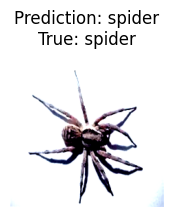

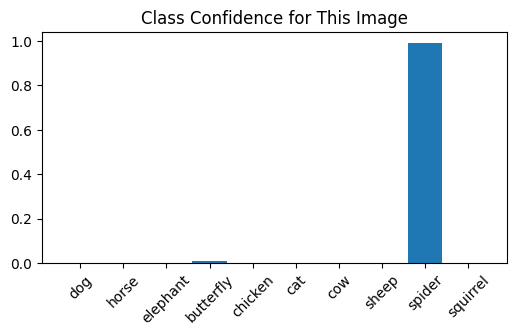

In [20]:
img_idx = 10  # Change this index to visualize a different image
plt.figure(figsize=(3,2))
img = all_imgs[img_idx].numpy().transpose(1,2,0) / 2 + 0.5
plt.imshow(img)
plt.axis('off')

pred_italian = full_dataset.classes[all_preds[img_idx]]
true_italian = full_dataset.classes[all_true[img_idx]]
pred_label = translate[pred_italian]
true_label = translate[true_italian]

plt.title(f'Prediction: {pred_label}\nTrue: {true_label}')
plt.show()

# Plot the class confidence as a bar chart
plt.figure(figsize=(6,3))
plt.bar(range(len(full_dataset.classes)), all_probs[img_idx].numpy())

# Translate x-axis labels to English using the updated translate dictionary
english_labels = [translate[italian] for italian in full_dataset.classes]
plt.xticks(range(len(full_dataset.classes)), english_labels, rotation=45)

plt.title("Class Confidence for This Image")
plt.show()

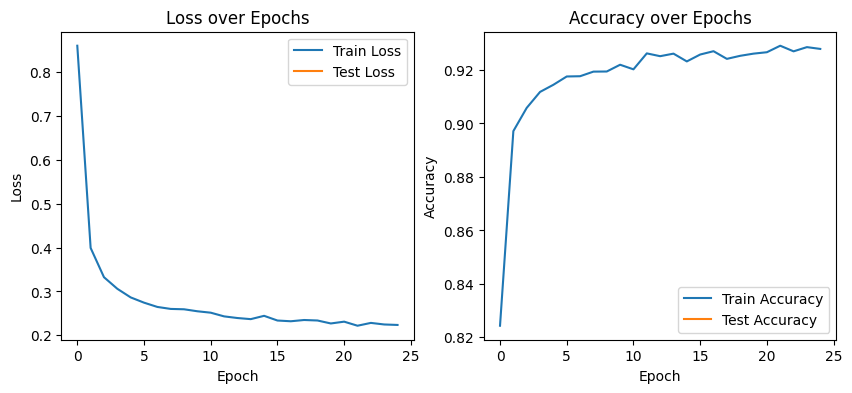

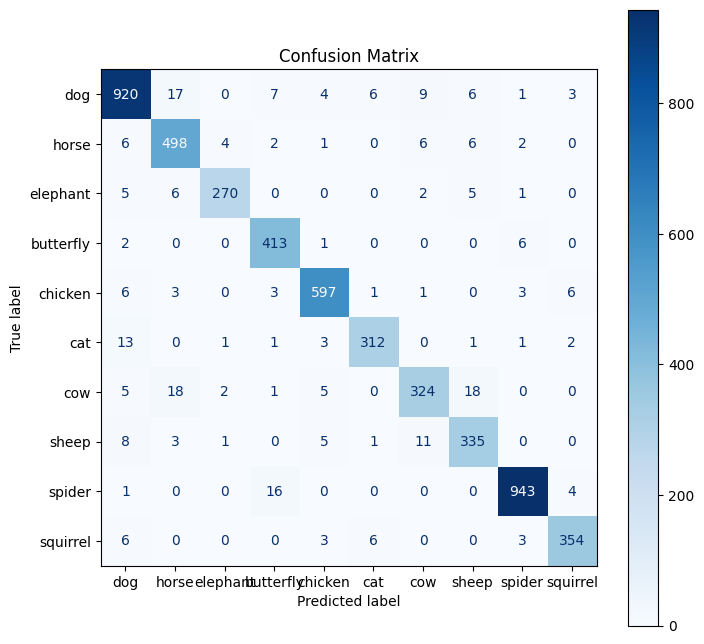

              precision    recall  f1-score   support

         dog       0.95      0.95      0.95       973
       horse       0.91      0.95      0.93       525
    elephant       0.97      0.93      0.95       289
   butterfly       0.93      0.98      0.95       422
     chicken       0.96      0.96      0.96       620
         cat       0.96      0.93      0.95       334
         cow       0.92      0.87      0.89       373
       sheep       0.90      0.92      0.91       364
      spider       0.98      0.98      0.98       964
    squirrel       0.96      0.95      0.96       372

    accuracy                           0.95      5236
   macro avg       0.94      0.94      0.94      5236
weighted avg       0.95      0.95      0.95      5236



In [21]:
# --- 5. Plot Confusion Matrix + Metric Curves ---
# Plot accuracy/loss curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Test Loss')
plt.legend()
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Test Accuracy')
plt.legend()
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

# Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(all_true, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=english_labels)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

from sklearn.metrics import classification_report
print(classification_report(all_true, all_preds, target_names=english_labels))

## What Does This Say About the Model?

EfficientNet-B0 outperforms basic CNNs on Animals10, showing the power of transfer learning from ImageNet.
Data augmentation (flipping, rotation, color jitter) significantly helped model robustness and reduced overfitting.
Very strong generalization: The train-test accuracy gap is small, so the model isn’t just memorizing training data.
All classes are classified accurately (F1 ≥ 0.89 for all), meaning the network learned distinctive features for each animal type.
Only a handful of confusion cases (e.g., sheep/cow, cat/dog), which could be due to natural visual similarity.